In [1]:
import gmsh
from mpi4py import MPI
from dolfinx.plot import vtk_mesh
import pyvista
import numpy as np
from petsc4py import PETSc
from mpi4py import MPI
from dolfinx import default_scalar_type
from dolfinx.io import gmshio 
import matplotlib.pyplot as plt 
from dolfinx import geometry
from dolfinx.mesh import locate_entities_boundary
from dolfinx.fem.petsc import LinearProblem
from scipy.constants import pi, epsilon_0
from dolfinx.fem import (Constant, dirichletbc, Function, Expression, functionspace, assemble_scalar,
                         form, locate_dofs_geometrical, locate_dofs_topological)
from ufl import (SpatialCoordinate, TestFunction, TrialFunction, as_vector,
                 dx, dot, grad, inner)

In [2]:
# GMSH
gdim = 2  # Dimension of the mesh (2D)
model_rank = 0
mesh_comm = MPI.COMM_WORLD


# Problem Parameters
gamma = 0.05  # Tensão superficial (N/m)
epsilon_r = 84  # Permissividade relativa
d = 6e-3  # Distância capilar-barrier (m)
R = 0.12e-3 / 2  # Raio do nozzle (m)
Rc = R  # Raio de curvatura igual ao nozzle
rho = 1.13e3  # Densidade (kg/m^3)
Rg = 0.002e-3  # Raio da gotícula (m)


e0 = 8.854187817e-10 # Electric permittivity of vacuum (F/m)

# Critical Eletric Field and Voltage
En_critical = np.sqrt(pi * gamma / (2 * e0 * R))
V_critical = np.sqrt((gamma * Rc) / epsilon_0) * np.log(4 * d / Rc)

print("Critical voltage is: ")
print(V_critical)

Critical voltage is: 
3487.540472567854


In [3]:
# Create mesh using gmsh
gmsh.initialize()

# Create objects
holes = []

air = gmsh.model.occ.addRectangle(0, 0, 0, 12e-3, 12e-3, tag=3)
gmsh.model.occ.synchronize()

barrier = gmsh.model.occ.addRectangle(5e-3, 9e-3, 0, 7e-3, R*2, tag=1)
gmsh.model.occ.synchronize()
holes.append((2,1))

nozzle =  gmsh.model.occ.addRectangle(0, 0, 0, R, 3e-3, tag=2)
gmsh.model.occ.synchronize()
circle = gmsh.model.occ.addDisk(0, 3e-3, 0, R, R)
gmsh.model.occ.synchronize()
nozzle_join = gmsh.model.occ.fuse([(2, nozzle)], [(2, circle)])
gmsh.model.occ.synchronize()
holes.append((2,2))

# Create domain
whole_domain, map_to_input = gmsh.model.occ.fragment([(2, air)], holes)
gmsh.model.occ.synchronize()

Info    : Cannot bind existing OpenCASCADE surface 2 to second tag 4                                                               
Info    : Could not preserve tag of 2D object 4 (->2)


In [4]:
# Add physical marker for cells. It is important to call this
# function after OpenCascade synchronization
gmsh.model.add_physical_group(dim=2, tags=[air],tag=1,name="air")
gmsh.model.add_physical_group(dim=2, tags=[nozzle],tag=2,name="nozzle")
gmsh.model.add_physical_group(dim=2, tags=[barrier],tag=3,name="barrier")
gmsh.model.occ.synchronize()

In [5]:
# Mesh size
#gmsh.option.setNumber("Mesh.CharacteristicLengthMin", z_cap/8)
gmsh.option.setNumber("Mesh.CharacteristicLengthMax", 1/(2**13))

gmsh.model.mesh.generate(2)

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 20%] Meshing curve 3 (Ellipse)
Info    : [ 30%] Meshing curve 4 (Line)
Info    : [ 30%] Meshing curve 5 (Line)
Info    : [ 40%] Meshing curve 6 (Line)
Info    : [ 50%] Meshing curve 7 (Line)
Info    : [ 50%] Meshing curve 8 (Line)
Info    : [ 60%] Meshing curve 9 (Line)
Info    : [ 70%] Meshing curve 10 (Line)
Info    : [ 70%] Meshing curve 11 (Line)
Info    : [ 80%] Meshing curve 12 (Line)
Info    : [ 90%] Meshing curve 13 (Line)
Info    : [ 90%] Meshing curve 14 (Ellipse)
Info    : [100%] Meshing curve 15 (Line)
Info    : Done meshing 1D (Wall 0.00200185s, CPU 0.001426s)
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : [ 30%] Meshing surface 2 (Plane, Frontal-Delaunay)
Info    : [ 60%] Meshing surface 3 (Plane, Frontal-Delaunay)
Info    : [ 80%] Meshing surface 4 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.32

In [6]:
# Converts the mesh created in GMSH to the format used by Dolfinx.
mesh,cell_tags,facet_tags = gmshio.model_to_mesh(gmsh.model, mesh_comm, model_rank, gdim=2)
# Finaliza o GMSH
#gmsh.write("mesh.msh")
gmsh.finalize()

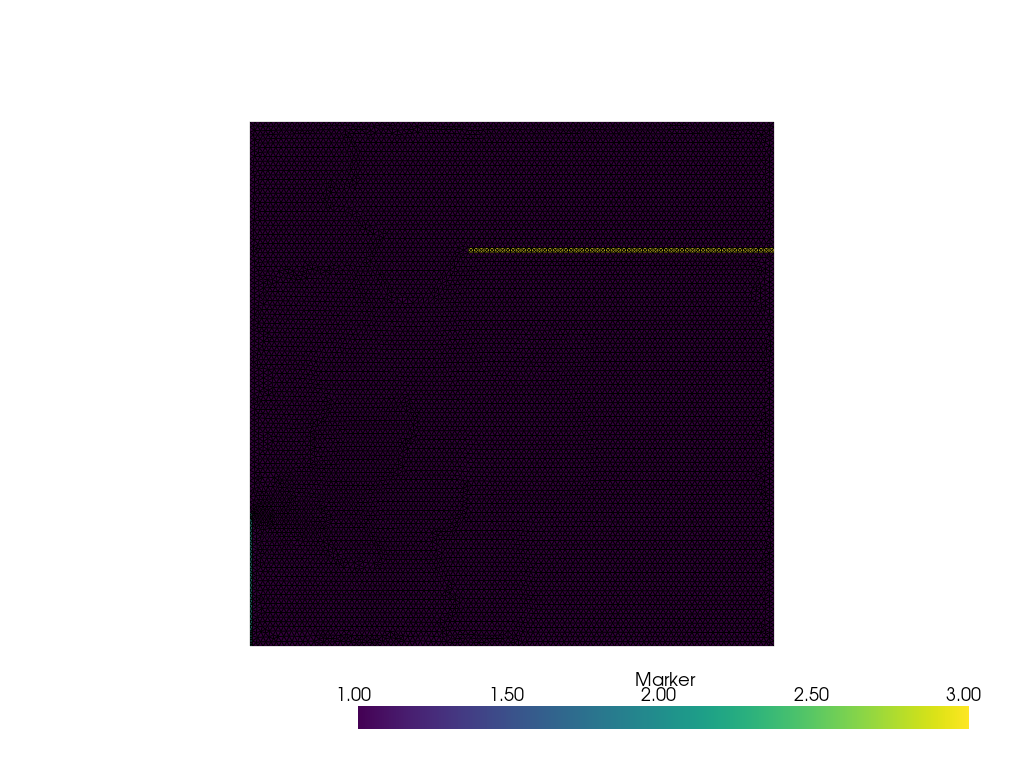

In [7]:
# Configura a visualização com PyVista
from dolfinx.plot import vtk_mesh
import pyvista
pyvista.start_xvfb()

# Configura a visualização com PyVista
plotter = pyvista.Plotter()
mesh.topology.create_connectivity(2, 2)
grid = pyvista.UnstructuredGrid(*vtk_mesh(mesh, 2))
num_local_cells = mesh.topology.index_map(2).size_local
grid.cell_data["Marker"] = cell_tags.values[cell_tags.indices < num_local_cells]
grid.set_active_scalars("Marker")

# Remova o color e use cmap para coloração baseada no "Marker"
actor = plotter.add_mesh(grid, show_edges=True, cmap="viridis", edge_color="black")

plotter.view_xy()
plotter.show()

In [8]:
Q = functionspace(mesh, ("DG", 0))

epsilon = Function(Q) #relative epsilon

Const_epsilon_0 = Constant(mesh, PETSc.ScalarType(e0))
Const_epsilon_r = Constant(mesh, PETSc.ScalarType(epsilon_r))

In [9]:
# List of elements in each domain
air_elements = cell_tags.find(9)
nozzle_elements = cell_tags.find(5)
block_elements = cell_tags.find(7)

# Defining the permeability values
epsilon.x.array[block_elements] = np.full_like(block_elements, Const_epsilon_0, dtype=default_scalar_type)
epsilon.x.array[nozzle_elements] = np.full_like(nozzle_elements, Const_epsilon_r, dtype=default_scalar_type)
epsilon.x.array[air_elements] = np.full_like(air_elements, Const_epsilon_0, dtype=default_scalar_type)

In [10]:
V = functionspace(mesh, ("Lagrange", 2))
tdim = mesh.topology.dim

x = SpatialCoordinate(mesh)
r = x[0]    # Radial axis


def boundary_nozzle(x):
    return np.logical_and(np.isclose(x[0], R), x[1] <= 5e-3)
     
def boundary_barrier(x):
    return np.logical_and(np.isclose(x[1], 9e-3), x[0] > 2e-3)


# Set dirichlet boundaries, one for each object

dofs_nozzle = locate_dofs_geometrical(V, boundary_nozzle)
dofs_barrier = locate_dofs_geometrical(V, boundary_barrier)

bc_nozzle = dirichletbc(PETSc.ScalarType(V_critical), dofs_nozzle, V)
bc_barrier = dirichletbc(PETSc.ScalarType(0), dofs_barrier, V)

In [11]:
u = TrialFunction(V)
v = TestFunction(V)

# Equação variacional com coordenadas cilíndricas
a =  r * dot(grad(u), grad(v)) * dx

# Segundo termo da forma fraca axissimétrica
L = v * dx

# Solving Problem
E_ = Function(V)        # A_ = r*A_alpha
problem = LinearProblem(a, L, u=E_, bcs=[bc_nozzle,bc_barrier])
problem.solve()

Coefficient(FunctionSpace(Mesh(blocked element (Basix element (P, triangle, 1, equispaced, unset, False, float64, []), (2,)), 0), Basix element (P, triangle, 2, gll_warped, unset, False, float64, [])), 1)

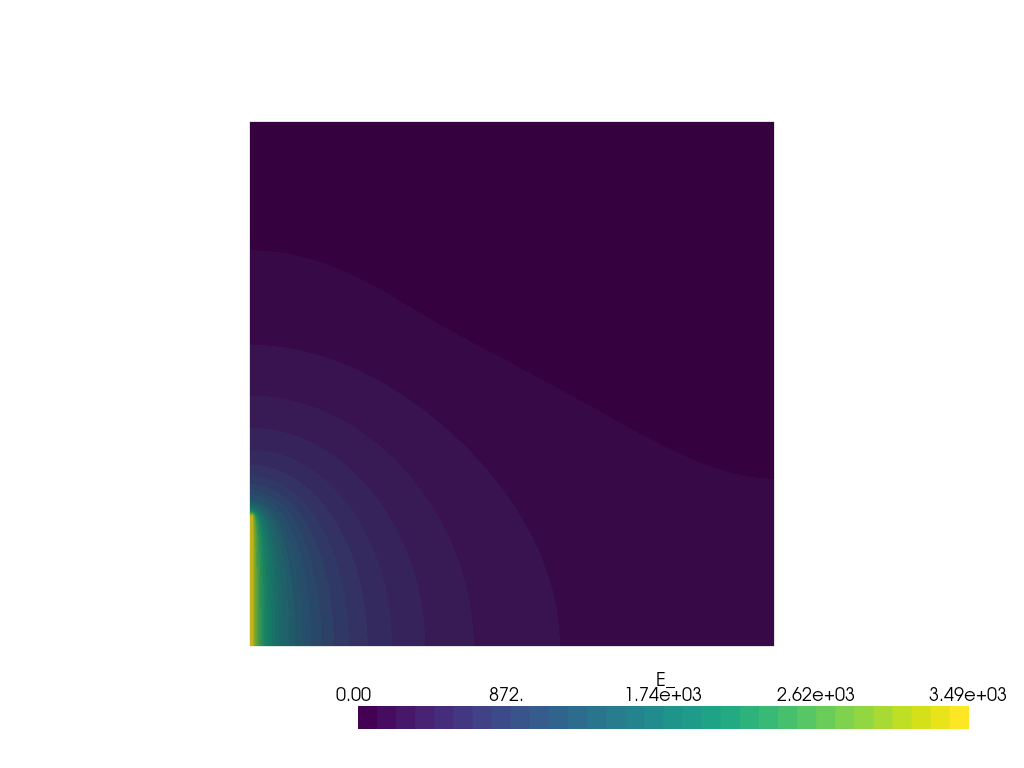

In [12]:
# Cria o plotter
plotter = pyvista.Plotter() 


# Converte a malha para um UnstructuredGrid
E_grid = pyvista.UnstructuredGrid(*vtk_mesh(V))

# Adiciona os dados do campo A_z
E_grid.point_data["E_"] = E_.x.array
E_grid.set_active_scalars("E_")

# Adiciona a malha deformada no plotter
actor = plotter.add_mesh(E_grid, show_edges=False,n_colors=32)
plotter.view_xy()
plotter.show()

In [13]:
# Calcular o campo eletrico
W = functionspace(mesh, ("DG", 0, (mesh.geometry.dim, )))
E = Function(W)
E_expr = Expression(as_vector((E_.dx(1), E_.dx(0))), W.element.interpolation_points())
E.interpolate(E_expr) 

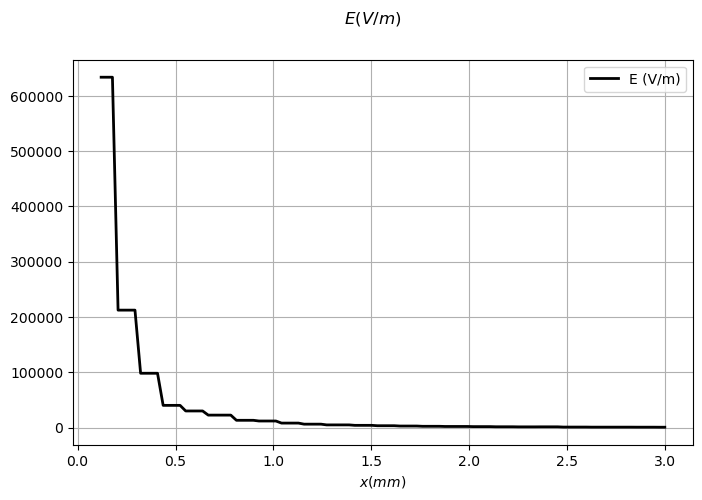

In [14]:
#Creating a balanced tree with the elements of the mesh
bb_tree = geometry.bb_tree(mesh, mesh.topology.dim) 

# sample points
x = np.linspace(3e-3+2*Rc, 6e-3, 101)
points = np.zeros((3, 101))
points[1] = x

E_values = []
cells = []
points_on_proc = []

# Find cells whose bounding-box collide with the the points
cell_candidates = geometry.compute_collisions_points(bb_tree, points.T)
# Choose one of the cells that contains the point
colliding_cells = geometry.compute_colliding_cells(mesh, cell_candidates, points.T)
for i, point in enumerate(points.T):
    if len(colliding_cells.links(i)) > 0:
        points_on_proc.append(point)
        cells.append(colliding_cells.links(i)[0])

points_on_proc = np.array(points_on_proc, dtype=np.float64)
E_values = E.eval(points_on_proc, cells)


# plot horizontal line
fig = plt.figure(figsize=(8,5))
plt.plot(x*1000 - 3, -E_values[:,1] , 'k', linewidth=2); # magnify w
plt.grid(True);
plt.xlabel('$x (mm)$');
plt.legend(['E (V/m)'], loc='upper right');
fig.suptitle("$E (V/m)$");

In [19]:

from scipy.constants import pi, epsilon_0
from scipy.integrate import solve_ivp

m = (4 / 3) * pi * Rg**3 * rho
Q = 8 * pi * np.sqrt(epsilon_0 * gamma )* Rg**(3 / 2)
x_axis = x
E = -E_values[:,1] - 3e-3


def droplet_dynamics(t, y):
    x, v = y
    indice_proximo = np.argmin(np.abs(x_axis - x))
    Fe = Q * E[indice_proximo] if x < d else 0
    a = Fe / m
    return [v, a]


t_span = (0, 0.2e-3)
y0 = [0, 0]
t_eval = np.linspace(*t_span, 500)
solution = solve_ivp(droplet_dynamics, t_span, y0)


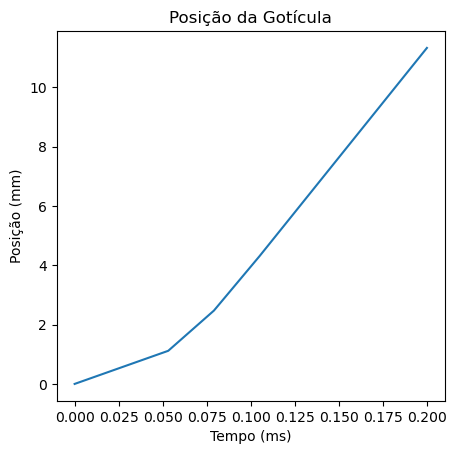

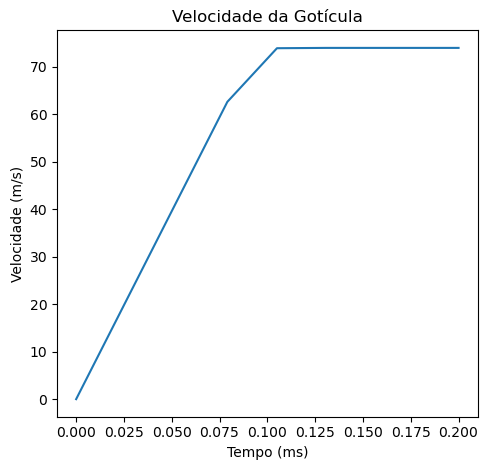

In [20]:
x_pos = solution.y[0]
v_vel = solution.y[1]


# Gráficos de posição e velocidade
plt.figure().set_figwidth(5)
plt.plot(solution.t*1e3, x_pos*1000)
plt.xlabel("Tempo (ms)")
plt.ylabel("Posição (mm)")
plt.title("Posição da Gotícula")

plt.figure().set_figwidth(5)
plt.plot(solution.t*1e3, v_vel)
plt.xlabel("Tempo (ms)")
plt.ylabel("Velocidade (m/s)")
plt.title("Velocidade da Gotícula")

plt.tight_layout()
plt.savefig("droplet_graphs.png")